### Import the relevant modules

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.regression.linear_model import OLS

C:\Users\natha\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\natha\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### Import the data

Text(0.5, 1.0, 'TSLA Close Price')

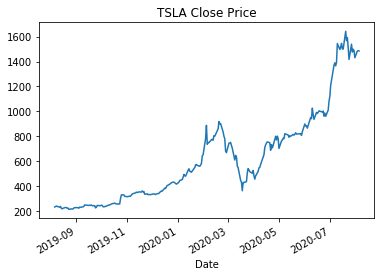

In [2]:
df = pd.read_csv("TSLA.csv", index_col=0, parse_dates=[0])
df.head()

df["Close"].plot()
plt.title("TSLA Close Price")

### Partialautocorrelation function

Text(0.5, 1.0, 'PACF')

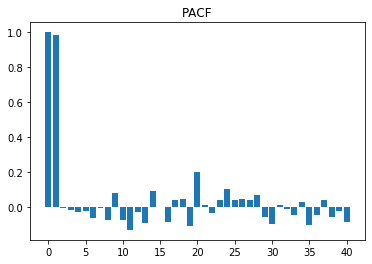

In [3]:
plt.bar(x=np.arange(0,41), height=pacf(df.Close))
plt.title("PACF")
## Finite, cuts off after lag 1 so AR

### Autocorrelation function

C:\Users\natha\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'ACF')

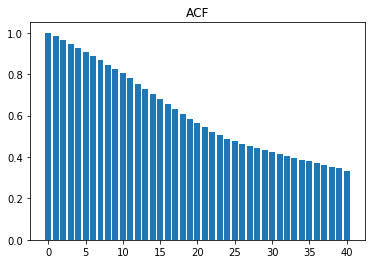

In [4]:
plt.bar(x=np.arange(0,41), height=acf(df.Close))
plt.title("ACF")
## Infinite and damps out so AR or ARMA

In [5]:
# Make it stationary by differencing
tsla = df.Close.diff().fillna(0)

# Create lag
tsla_lag_1 = tsla.shift(1).fillna(0)

Text(0.5, 1.0, 'TSLA Returns')

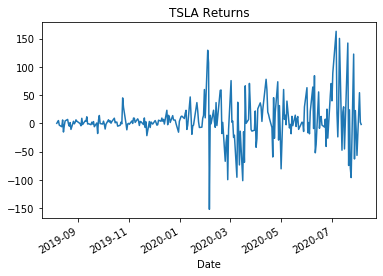

In [6]:
tsla.plot()
plt.title("TSLA Returns")

In [7]:
# Put all into one DataFrame

df_regression = pd.DataFrame(tsla)
df_regression["Lag1"] = tsla_lag_1

# Split into train and test data
df_regression_train = df_regression.iloc[0:200]
df_regression_test = df_regression.iloc[200:]

### Run rolling regression to find optimal window

In [8]:
n = 0
rsquared = []

while n<=30:
    
    y = df_regression_train["Close"].iloc[-n:]
    x = df_regression_train["Lag1"].iloc[-n:]
    x = sm.add_constant(x)

    model = sm.OLS(y,x)
    results = model.fit()

    rsquared.append(results.rsquared)

    n +=1

C:\Users\natha\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Text(0.5, 0, 'Observation')

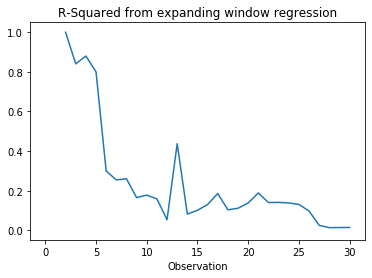

In [9]:
plt.plot(rsquared)

rsquared.index(0.43737319899293914)
plt.title("R-Squared from expanding window regression")
plt.xlabel("Observation")

### AR(1) model with static coefficients - training data

In [10]:
y = df_regression_train["Close"].iloc[-13:]
x = df_regression_train["Lag1"].iloc[-13:]
x = sm.add_constant(x)

model = sm.OLS(y,x)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     8.551
Date:                Thu, 06 Aug 2020   Prob (F-statistic):             0.0138
Time:                        18:34:58   Log-Likelihood:                -53.741
No. Observations:                  13   AIC:                             111.5
Df Residuals:                      11   BIC:                             112.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6456      4.564      2.114      0.0

C:\Users\natha\Anaconda3\lib\site-packages\scipy\stats\stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


### Fit AR(1) model to training data 

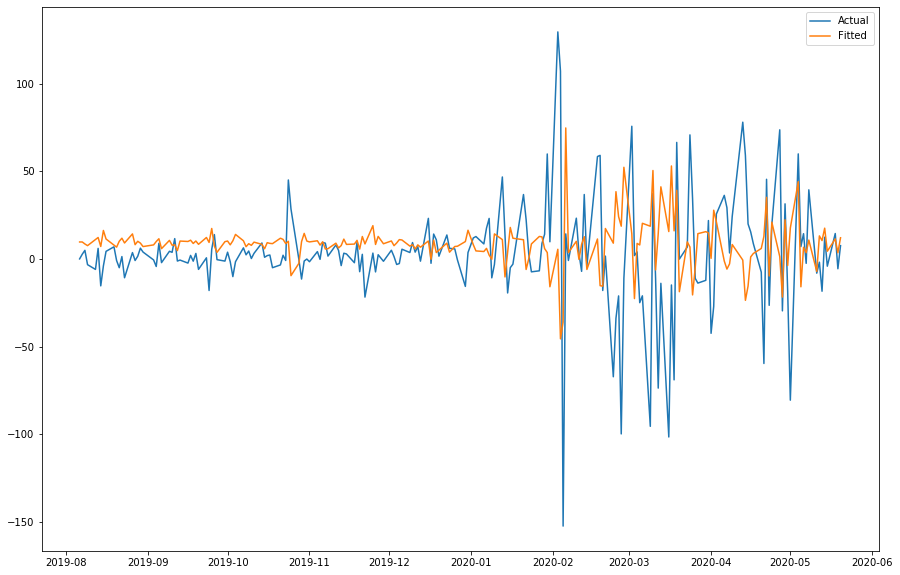

In [11]:
fitted = 9.6456 + -0.4268*df_regression_train["Lag1"]

ax = plt.figure(figsize=(15,10))
plt.plot(df_regression_train["Close"])
plt.plot(fitted)
plt.legend(["Actual","Fitted"])


In [12]:
# Combine into one DataFrame
df_2 = pd.DataFrame({"Fitted Value":fitted,
                        "Actual":df_regression_train["Close"]})

In [13]:
# Calculate residuals
df_2["Residuals"] = df_2["Fitted Value"] - df_2["Actual"]

Text(0.5, 1.0, 'Residuals')

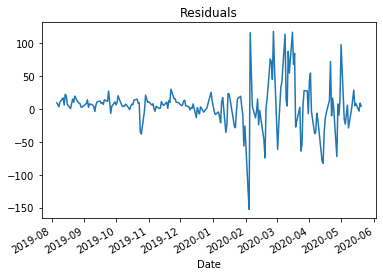

In [14]:
df_2.Residuals.plot()
plt.title("Residuals")

### Calculate hit rate (train data)

In [15]:
true_neg = np.sum((df_2["Fitted Value"] <0) & (df_2["Actual"] <0))


In [16]:
true_pos = np.sum((df_2["Fitted Value"] >0) & (df_2["Actual"] >0))

In [17]:
accuracy = (true_neg + true_pos)/len(df_2)
accuracy

0.545

### Apply AR(1) Model to Test data
### Yt = 9.6456 -0.4268Yt-1 + ε

Text(0.5, 1.0, 'Actual vs Fitted - Test Data')

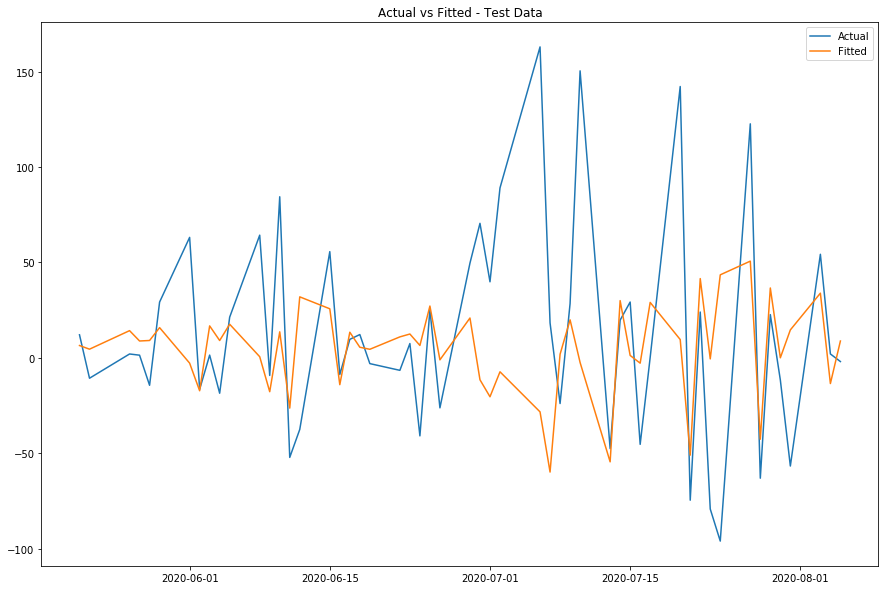

In [18]:
fitted_test = 9.6456 + -0.4268*df_regression_test["Lag1"]
ax = plt.figure(figsize=(15,10))

plt.plot(df_regression_test["Close"])
plt.plot(fitted_test)
plt.legend(["Actual","Fitted"])
plt.title("Actual vs Fitted - Test Data")

In [19]:
# Combine into one DataFrame
df_2_test = pd.DataFrame({"Fitted Value":fitted_test,
                        "Actual":df_regression_test["Close"]})

Text(0.5, 1.0, 'Residuals - Test Data')

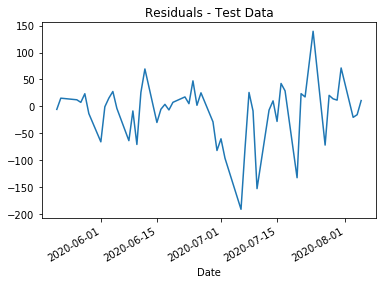

In [20]:
# Calculate residuals
df_2_test["Residuals"] = df_2_test["Fitted Value"] - df_2_test["Actual"]
df_2_test["Residuals"].plot()
plt.title("Residuals - Test Data")

### Calculate hit rate (test data)

In [21]:
true_neg_test = np.sum((df_2_test["Fitted Value"] <0) & (df_2_test["Actual"] <0))
true_pos_test = np.sum((df_2_test["Fitted Value"] >0) & (df_2_test["Actual"] >0))

accuracy = (true_neg_test + true_pos_test)/len(df_2_test)
accuracy

0.6415094339622641